In [12]:
import pandas as pd
import matplotlib.pyplot as plt 
import numpy as np
import seaborn as sns
import os
import joblib
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from main.utils import data_manage_utils

# Variables
ROOT_PATH = os.path.abspath("../../")
INPUT_FOLDER = os.path.join(ROOT_PATH, "data/preparation/prepped_files")
OUTPUT_FOLDER = os.path.join(ROOT_PATH, "data/preprocessing/base")

In [13]:
data = pd.read_pickle(os.path.join(INPUT_FOLDER, "08_converted.pkl"))
data

,MEDIAN_CARR_DELAY(MINS),MEDIAN_ORIGIN_DELAY(MINS),DEP_DELAY(MINS),CRS_ELAPSED_TIME(MINS),DISTANCE(KM),NR_PREV_ARR_FLIGHTS(1HR),ARR_DAY_SIN,ARR_DAY_COS,ARR_MIN_OF_DAY_SIN,ARR_MIN_OF_DAY_COS,...,EVENT_IC,EVENT_RA,EVENT_SN,EVENT_TS,08L/26R,08R/26L,09L/27R,09R/27L,10/28,ARR_DELAY_MINS
5626534,-11.0,-8.0,-2,223,2558.85060,4,-0.781831,0.62349,0.986286,-0.165048,...,0,1,0,0,1.0,1.0,1.0,1.0,1.0,-7
5627321,-8.0,-8.0,-4,88,650.17336,5,-0.781831,0.62349,0.982450,-0.186524,...,0,1,0,0,1.0,1.0,1.0,1.0,1.0,-11
5622325,-8.0,-7.0,302,57,170.59004,7,-0.781831,0.62349,0.979925,-0.199368,...,0,1,0,0,1.0,1.0,1.0,1.0,1.0,333
5626430,-11.0,-9.0,-2,98,719.37498,6,-0.781831,0.62349,0.956305,-0.292372,...,0,1,0,0,1.0,1.0,1.0,1.0,1.0,11
5625623,-11.0,-9.0,-4,76,363.71084,7,-0.781831,0.62349,0.945519,-0.325568,...,0,1,0,0,1.0,1.0,1.0,1.0,1.0,-8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11291377,-11.0,-9.0,-11,220,2811.51698,2,0.000000,1.00000,0.985556,-0.169350,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,-20
11292052,-11.0,-6.0,-2,264,3366.73928,2,0.000000,1.00000,0.977231,-0.212178,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,-26
11290999,-11.0,-5.0,-1,246,3133.38498,3,0.000000,1.00000,0.960050,-0.279829,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0
11290527,-11.0,-11.0,-4,276,3442.37826,4,0.000000,1.00000,0.958820,-0.284015,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,-33


## Target Variable
The target variable is to be created. As found in the [analysis/classification_target_distribution.ipynb]() file. I chose the FAA fitting version that classifies flights within -15 minutes and +15 minutes delay as on time while being too early or too late when arriving before or after these limits respectively

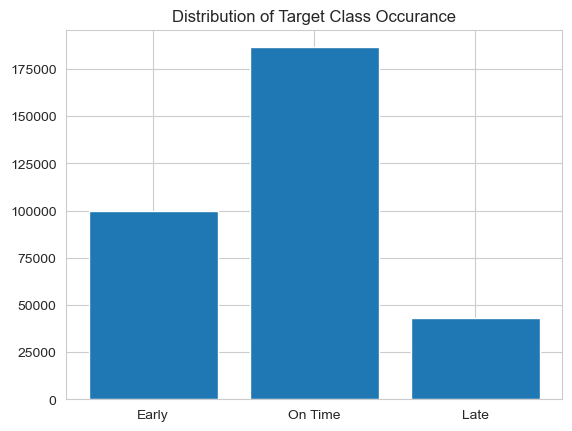

In [14]:
delays = data.ARR_DELAY_MINS.to_numpy()

# Formulating limits and labels of binning
bins = [delays.min() - 1, -15, 15, delays.max() + 1]
labels = ["Early", "On Time", "Late"]

# Creating dict for transition from cat to numerical
trans_dict = {}
for count, label in enumerate(labels):
    trans_dict.update({
        label: count
    })

# Do the binning
binned = pd.cut(data.ARR_DELAY_MINS, bins, labels=labels, include_lowest=True)

# Insert correct categorical number
data["ARR_DELAY_CATS"] = binned.apply(lambda x: trans_dict.get(x))
data
fig, ax = plt.subplots()

count_dict = data.ARR_DELAY_CATS.value_counts().to_dict()
count_dict = dict(sorted(count_dict.items()))
X = ["Early", "On Time", "Late"]
Y = count_dict.values()

ax.set_title("Distribution of Target Class Occurance")
ax.bar(X, Y)
plt.show()

In [15]:
data

,MEDIAN_CARR_DELAY(MINS),MEDIAN_ORIGIN_DELAY(MINS),DEP_DELAY(MINS),CRS_ELAPSED_TIME(MINS),DISTANCE(KM),NR_PREV_ARR_FLIGHTS(1HR),ARR_DAY_SIN,ARR_DAY_COS,ARR_MIN_OF_DAY_SIN,ARR_MIN_OF_DAY_COS,...,EVENT_RA,EVENT_SN,EVENT_TS,08L/26R,08R/26L,09L/27R,09R/27L,10/28,ARR_DELAY_MINS,ARR_DELAY_CATS
5626534,-11.0,-8.0,-2,223,2558.85060,4,-0.781831,0.62349,0.986286,-0.165048,...,1,0,0,1.0,1.0,1.0,1.0,1.0,-7,1
5627321,-8.0,-8.0,-4,88,650.17336,5,-0.781831,0.62349,0.982450,-0.186524,...,1,0,0,1.0,1.0,1.0,1.0,1.0,-11,1
5622325,-8.0,-7.0,302,57,170.59004,7,-0.781831,0.62349,0.979925,-0.199368,...,1,0,0,1.0,1.0,1.0,1.0,1.0,333,2
5626430,-11.0,-9.0,-2,98,719.37498,6,-0.781831,0.62349,0.956305,-0.292372,...,1,0,0,1.0,1.0,1.0,1.0,1.0,11,1
5625623,-11.0,-9.0,-4,76,363.71084,7,-0.781831,0.62349,0.945519,-0.325568,...,1,0,0,1.0,1.0,1.0,1.0,1.0,-8,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11291377,-11.0,-9.0,-11,220,2811.51698,2,0.000000,1.00000,0.985556,-0.169350,...,0,0,0,0.0,0.0,0.0,0.0,0.0,-20,0
11292052,-11.0,-6.0,-2,264,3366.73928,2,0.000000,1.00000,0.977231,-0.212178,...,0,0,0,0.0,0.0,0.0,0.0,0.0,-26,0
11290999,-11.0,-5.0,-1,246,3133.38498,3,0.000000,1.00000,0.960050,-0.279829,...,0,0,0,0.0,0.0,0.0,0.0,0.0,0,1
11290527,-11.0,-11.0,-4,276,3442.37826,4,0.000000,1.00000,0.958820,-0.284015,...,0,0,0,0.0,0.0,0.0,0.0,0.0,-33,0


In [16]:
OUTPUT_FOLDER

'C:\\Users\\chrig\\PycharmProjects\\PertubationThesis\\data/preprocessing/base'

In [17]:
if not os.path.exists(OUTPUT_FOLDER): 
    os.makedirs(OUTPUT_FOLDER)
pd.to_pickle(data, os.path.join(OUTPUT_FOLDER, "data.pkl"))